In [184]:
from __future__ import annotations
import numpy as np
import six
import math
from matplotlib import pyplot
from pandas import DataFrame, read_csv as csv
import gc

In [185]:
def show(
    data: DataFrame,
    decimals: int = 3,
    colwidth: int | float = 3.0,
    rowheight: int | float = 0.625,
    fontsize: int | float = 14,
    headercolor: str = '#40466e',
    rowcolors: list[str] = None,
    edgecolor: str = 'w',
    bbox: list[int] = None,
    headercolumns: int = 0,
    ax = None,
    **kwargs
):
    gc.collect()
    if bbox is None:
        bbox = [0, 0, 1, 1]
    if rowcolors is None:
        rowcolors = ['#f1f1f2', 'w']
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([colwidth, rowheight])
        fig, ax = pyplot.subplots(figsize = size)
        ax.axis('off')

    val = np.round(data.values, decimals = decimals)
    mtable = ax.table(cellText = val, bbox = bbox, colLabels = data.columns, **kwargs)

    mtable.auto_set_font_size(False)
    mtable.set_fontsize(fontsize)

    for k, cell in six.iteritems(mtable.get_celld()):
        cell.set_edgecolor(edgecolor)
        if k[0] == 0 or k[1] < headercolumns:
            cell.set_text_props(weight = 'bold', color = 'w')
            cell.set_facecolor(headercolor)
        else:
            cell.set_facecolor(rowcolors[k[0] % len(rowcolors)])
    pyplot.show()
    #return ax

In [186]:
from enum import Enum, unique


@unique
class Operation(Enum):
    ADD = 0
    SUB = 1
    MUL = 2
    TRUEDIV = 3
    FLOORDIV = 4
    POW = 5
    MOD = 6


class LException(Exception):

    def __init__(self, *args):
        super(LException, self).__init__(*args)


class List(list):

    def __init__(self):
        super().__init__()

    def __add__(self, other: int | float | List):
        return self.__aux(other, Operation.ADD)

    def __sub__(self, other: int | float | List):
        return self.__aux(other, Operation.SUB)

    def __mul__(self, other: int | float | List):
        return self.__aux(other, Operation.MUL)

    def __truediv__(self, other: int | float | List):
        return self.__aux(other, Operation.TRUEDIV)

    def __floordiv__(self, other: int | float | List):
        return self.__aux(other, Operation.FLOORDIV)

    def __pow__(self, power: int | List, modulo = None):
        return self.__aux(power, Operation.POW)

    def __mod__(self, other: int | float | List):
        return self.__aux(other, Operation.MOD)

    def __op(self, other: int | float | List, operation: Operation, array: bool = False) -> List:
        values = List()
        for i in range(len(self)):
            if operation == Operation.ADD:
                values.append(self[i] + other[i] if array else self[i] + other)
            elif operation == Operation.SUB:
                values.append(self[i] - other[i] if array else self[i] - other)
            elif operation == Operation.MUL:
                values.append(self[i] * other[i] if array else self[i] * other)
            elif operation == Operation.TRUEDIV:
                values.append(self[i] / other[i] if array else self[i] / other)
            elif operation == Operation.FLOORDIV:
                values.append(self[i] // other[i] if array else self[i] // other)
            elif operation == Operation.POW:
                values.append(self[i] ** other[i] if array else self[i] ** other)
            elif operation == Operation.MOD:
                values.append(self[i] % other[i] if array else self[i] % other)
            else:
                raise LException(f"invalid operation")
        return values

    def __aux(self, other: int | float | List, op: Operation):
        if isinstance(other, (int, float)):
            return self.__op(other, op)
        elif isinstance(other, List):
            if len(self) == len(other):
                return self.__op(other, op, array = True)
            else:
                raise LException(f"lists must be of equal size")
        else:
            raise LException(f"only types are supported: {int}, {float} and {List}")


In [187]:
def invert(array: List) -> List:
    val = List()
    for i in range(len(array[0])):
        aux = List()
        for j in range(len(array)):
            aux.append(array[j][i])
        val.append(aux)
    return val

In [188]:
from csv import writer, reader


class LRException(Exception):
    def __init__(self, *args):
        super(LRException, self).__init__(*args)


class LinearRegression:

    def __init__(self, data: dict | str):
        self.__array: dict
        self.__path: str

        if isinstance(data, dict):
            self.__array = data
        elif isinstance(data, str):
            self.__path = data
            self.__array = {key: value for key, value in self.__readcsv()}
        else:
            raise LRException(f'Required data types: {dict} or path of *.csv file {str}')

        self.__n = len(self)

        self.__promx = np.mean(self["tan α"])
        self.__promy = np.mean(self["I[A]"])

        self.__sumx = np.sum(self["tan α"])
        self.__sumy = np.sum(self["I[A]"])
        self.__sumx2 = np.sum(self["tan α"] ** 2)
        self.__sumy2 = np.sum(self["I[A]"] ** 2)
        self.__sumxy = np.sum(self["tan α"] * self["I[A]"])

        self.__sumyaxb2 = np.sum((self["I[A]"] - (self["tan α"] * self.a()) - self.b()) ** 2)

    def __len__(self):
        return self.dimension()[1]

    def __getitem__(self, index):
        try:
            return self.__array[index]
        except KeyError as e:
            raise LRException(f"column {e} does not exist")

    def __setitem__(self, index, value):
        self.__array[index] = value

    def __readcsv(self):
        with open(self.__path, newline = '') as file:
            values = List()
            for f in reader(file):
                values.append(f)
            values = invert(values)
            for val in values:
                J = List()
                for gg in val[1:]:
                    J.append(float(gg))
                yield str(val[0]), J

    def __writecsv(self):
        with open(self.__path, mode = 'w') as File:
            write = writer(File)
            write.writerow(self.__array)

    def a(self) -> float:
        return (self.__n * self.__sumxy - self.__sumx * self.__sumy) / (self.__n * self.__sumx2 - self.__sumx ** 2)

    def b(self) -> float:
        return (self.__sumy * self.__sumx2 - self.__sumx * self.__sumxy) / (self.__n * self.__sumx2 - self.__sumx ** 2)

    def r(self) -> float:
        return self.__sumxy / math.sqrt(self.__sumx2 * self.__sumy2)

    def sigmay(self):
        Y = self["I[A]"]
        BX = self["tan α"] * self.a()
        F = ((Y - BX) - self.b()) ** 2
        return math.sqrt(
            self.__sumyaxb2 / (self.__n - 2)
        )

    def erra(self):
        return self.sigmay() * math.sqrt(self.__n / (self.__n * self.__sumx2 - self.__sumx ** 2))

    def errb(self):
        return self.sigmay() * math.sqrt(self.__sumx2 / (self.__n * self.__sumx2 - self.__sumx ** 2))

    def table(
        self,
        decimals: int = 3,
        colwidth: int | float = 3.0,
        rowheight: int | float = 0.625,
        fontsize: int | float = 14,
        headercolor: str = '#40466e',
        rowcolors: list[str] = None,
        edgecolor: str = 'w',
        bbox: list[int] = None,
        headercolumns: int = 0,
        ax = None,
        **kwargs
    ) -> None:
        if bbox is None:
            bbox = [0, 0, 1, 1]
        if rowcolors is None:
            rowcolors = ['#f1f1f2', 'w']
        if ax is None:
            size = (np.array(self.dimension()) + np.array([0, 1])) * np.array([colwidth, rowheight])
            fig, ax = pyplot.subplots(figsize = size)
            ax.axis('off')
        values = [i for i in self.__array.values()]
        values = np.round(values, decimals = decimals)
        values = invert(values)
        mtable = ax.table(cellText = values, bbox = bbox, colLabels = self.headers(), **kwargs)
        mtable.auto_set_font_size(False)
        mtable.set_fontsize(fontsize)

        for k, cell in six.iteritems(mtable.get_celld()):
            cell.set_edgecolor(edgecolor)
            if k[0] == 0 or k[1] < headercolumns:
                cell.set_text_props(weight = 'bold', color = 'w')
                cell.set_facecolor(headercolor)
            else:
                cell.set_facecolor(rowcolors[k[0] % len(rowcolors)])
        pyplot.show()

    def graph(self) -> None:
        pass

    def dimension(self) -> tuple:
        row = 0
        for v in self.__array.values():
            row = len(v)
        return len(self.__array), row

    def headers(self) -> list:
        return [k for k in self.__array.keys()]

    def regression(self, x, y):
        pass

    def equation(self) -> str:
        return f"y = {round(self.a(), 2)}x + {round(self.b(), 2)}"

    def getarray(self):
        return self.__array

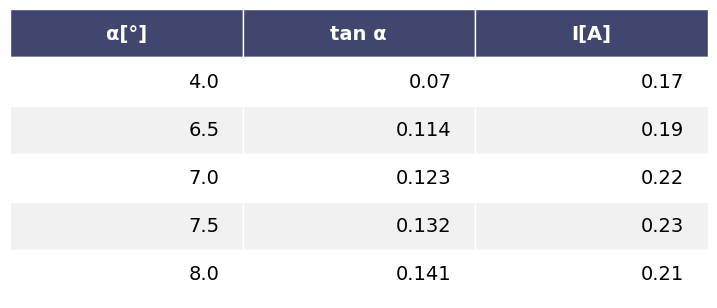

In [189]:
ls = LinearRegression("../lab10/models/datas.csv")
ls.table()

In [190]:
ls.b()

0.1176655737704925

In [191]:
ls.a()

0.7442622950819633

In [192]:
ls.r()

0.9913297022385562

In [193]:
ls.equation()

'y = 0.74x + 0.12'

In [194]:
ls.sigmay()

0.01449740885082497

In [195]:
ls.erra()

0.2625067451985696

In [196]:
ls.errb()

0.031133344248098174

# EXPERIMENTO 10: "LEY DE OERSTED"


El objetivo de esta experiencia es recrear el famoso experimento de Oersted sobre la desviación que sufre una aguja magnética situada en las proximidades de un conductor eléctrico

Através de esta ley se puede determinar el valor de **campo magnético** de un conductor

$$ \vec{B}_C = \frac{\mu_0 I}{2 \pi d} $$

referencias:
* $I \longrightarrow $ medir en laboratorio
* $d \longrightarrow $ distancia de separación entre el conductor y la aguja

In [197]:
df = DataFrame(csv("../lab10/models/datas.csv"))

df['tan α'] = df["α[°]"].apply(lambda a: math.tan(math.radians(a)))
# show(df, decimals = 2)
# df.shape[::-1]
print(df.columns)

Index(['α[°]', 'tan α', 'I[A]'], dtype='object')


**APLICANDO EL MÉTODO DE LOS MÍNIMOS CUADRADOS**
* Ecuación de la recta:
$$y = Bx + A$$
* Para determinar el término independiente $A$
$$
A =
\frac{\sum y_i \sum {x_i}^{2} - \sum x_i \sum x_i y_i}
{n \sum{x_i}^{2} - \left( \sum x_i \right)^{2}}
$$
* Para determinar la pendiente $B$
$$
B =
\frac{n\sum x_i y_i - \sum x_i \sum y_i}
{n \sum{x_i}^{2} - \left( \sum x_i \right)^{2}}
$$
* Para determinar la incertidumbre de los datos
$$
\sigma_y =
\sqrt{
\frac{\sum{\left(y_i - Bx_i - A\right)}^{2}}
{n-2}
}
$$
* Para determinar la incertidumbre de $A$
$$
E_A = \sigma_y \sqrt{
\frac{\sum{x_i}^{2}}{n \sum{x_i}^{2} - \left( \sum x_i \right)^{2}}
}
$$
* Para determinar la incertidumbre de $B$
$$
E_B = \sigma_y \sqrt{
\frac{n}{n \sum{x_i}^{2} - \left( \sum x_i \right)^{2}}
}
$$
* Para determinar el coeficiente de correlación
$$
r =
\frac{\sum x_i y_i}
{\sqrt{\sum{x_i}^{2} \sum{y_i}^{2}}}
$$

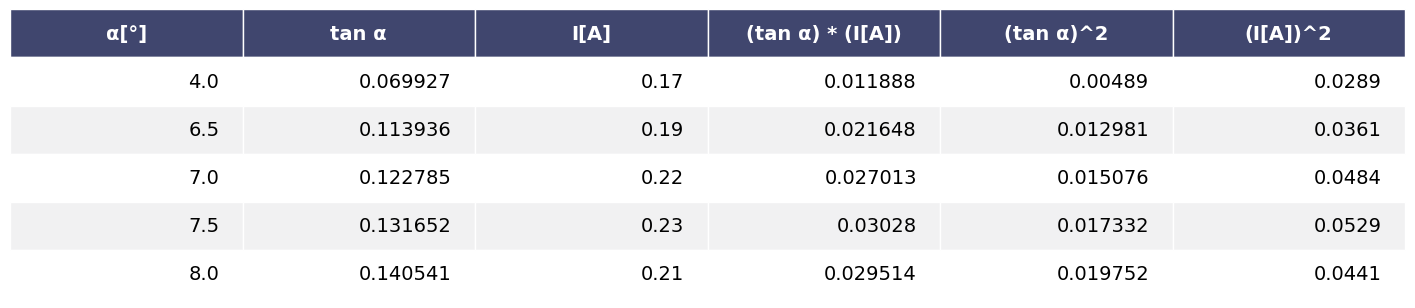

In [198]:
df['(tan α) * (I[A])'] = df["tan α"].apply(lambda a: a) * df["I[A]"].apply(lambda a: a)
df["(tan α)^2"] = df["tan α"].apply(lambda a: a) ** 2
df["(I[A])^2"] = df["I[A]"].apply(lambda a: a) ** 2
show(df, decimals = 6)

In [199]:
n = len(df)
sum_xy = np.sum(df["(tan α) * (I[A])"])
sum_x = np.sum(df["tan α"])
sum_y = np.sum(df["I[A]"])
sum_x2 = np.sum(df["(tan α)^2"])
sum_y2 = np.sum(df["(I[A])^2"])

Cantidad de datos

In [200]:
n

5

Pendiente de la recta

In [201]:
B = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x ** 2)
round(B, 2)

0.75

Término independiente

In [202]:
A = (sum_y * sum_x2 - sum_x * sum_xy) / (n * sum_x2 - sum_x ** 2)
round(A, 2)

0.12

Coeficiente de correlación

In [203]:
r = sum_xy / math.sqrt(sum_x2 * sum_y2)
round(r, 2)

0.99

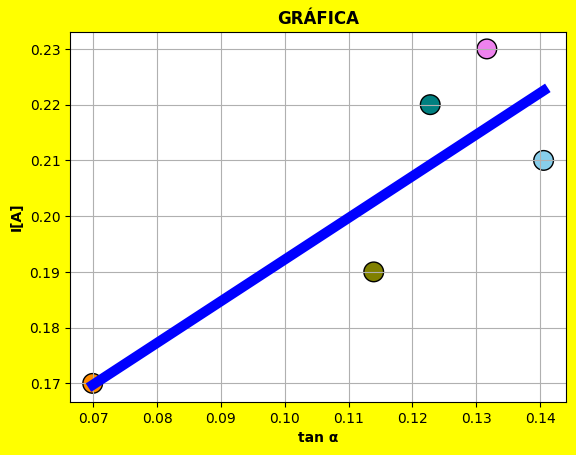

In [204]:
n_lines = 10
diff_linewidth = 1.05
alpha_value = 0.03
#pyplot.style.use("seaborn-dark")
color = ['darkorange', 'olive', 'teal', 'violet', 'skyblue']
pyplot.figure(facecolor = 'yellow')
pyplot.scatter(df["tan α"], df["I[A]"], edgecolors = "black", c = color, s = 200, marker = "o")
pyplot.plot(df["tan α"], B * df["tan α"] + A, c = "blue", linewidth = 2 + (diff_linewidth * n))
pyplot.xlabel("tan α", fontweight = "bold")
pyplot.ylabel("I[A]", fontweight = "bold")
pyplot.title("GRÁFICA", fontweight = "bold")
pyplot.grid()
#ax = pyplot.axes()
#ax.set_facecolor("violet")
pyplot.savefig('myfig100.png', dpi = 800)
pyplot.show()

,α[°],tan α,I[A],(tan α) * (I[A]),(tan α)^2,(I[A])^2
0,4.0,0.069927,0.17,0.011888,0.004890,0.0289
1,6.5,0.113936,0.19,0.021648,0.012981,0.0361
2,7.0,0.122785,0.22,0.027013,0.015076,0.0484
3,7.5,0.131652,0.23,0.030280,0.017332,0.0529
4,8.0,0.140541,0.21,0.029514,0.019752,0.0441


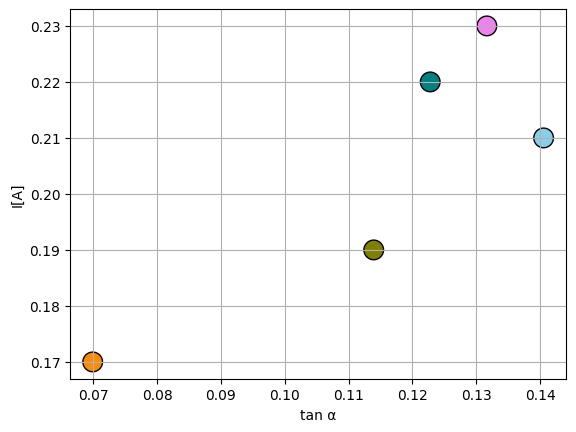

In [205]:
df.plot.scatter("tan α", "I[A]", edgecolors = "black", c = color, s = 200, marker = "o", grid = True)
df